# Begin visualisations

 ## todo


 1. Improve logistic regression by adding thresholds and finding the correct ones for same author.
 1. Tighten the threshold window down to 1%. 
 1. Run the code against different authors. 
 1. Does the damn thing work?
 1. Are graphs showing actual human behavior?
 1. annotate edges in dataset
 1. regenerate all data
 1. document and lock sequence alignment version
 1. fully remove and document removal of n-grams
 1. display more easy to see
 1. full dataset
 1. moving to dissertation; initial check against tarah's dataset
 1. do full relevant close re-reading

 ## done 

  1. Use Pickle or CSV to store values from dataframes so they don't have to be continuously regenerated. 

In [1]:
from pathlib import Path
import pandas as pd
import sqlite3
import networkx as nx
#import matplotlib.pyplot as plt
from ipycytoscape import CytoscapeWidget
from sqlite3 import OperationalError
from contextlib import suppress
import ipywidgets as widgets
from pprint import pprint
import py4cytoscape as p4c
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count
import os





In [2]:
working = Path('..')
working

PosixPath('..')

In [3]:
!pwd

/Users/tarah/Library/Mobile Documents/com~apple~CloudDocs/ONGOING-Oxford/OxfordTree/oxford_uni/dh-trace/notebooks


In [4]:
!ls $working

LICENSE                    load_hapaxes.py
Project History.pdf        load_jaccard.py
README.md                  load_ngram_intersects.py
__pycache__                load_ngrams.py
arch                       load_relationships.py
authors.txt                make_3d_plot.py
auto_author_prediction.py  make_auto_scatterplot.py
begin.sh                   make_confusion.py
cleaning_splitting_scripts make_dash.py
cytoscape-layouts          make_histogram.py
database_ops.py            make_jumbo_dash.py
dh-trace-venv              make_lines.py
diagrams.ipynb             notebooks
do_svm.py                  poetry.lock
do_viz.sh                  predict_ops.py
explore                    projects
hapaxes_1tM.py             pyproject.toml
init_db.py                 requirements.txt
jan24                      show_previous_averages.py
load_alignments.py         util.py
load_authors_and_texts.py  utils
load_hapax_intersects.py


In [5]:
things = working.glob('*')

In [6]:
for thing in things:
    print(thing)

../make_dash.py
../database_ops.py
../diagrams.ipynb
../.DS_Store
../LICENSE
../requirements.txt
../cleaning_splitting_scripts
../make_lines.py
../util.py
../auto_author_prediction.py
../make_confusion.py
../projects
../pyproject.toml
../predict_ops.py
../load_jaccard.py
../do_viz.sh
../utils
../cytoscape-layouts
../__pycache__
../load_hapaxes.py
../Project History.pdf
../jan24
../explore
../README.md
../load_ngram_intersects.py
../load_hapax_intersects.py
../load_ngrams.py
../.gitignore
../arch
../load_alignments.py
../make_jumbo_dash.py
../begin.sh
../load_authors_and_texts.py
../hapaxes_1tM.py
../make_auto_scatterplot.py
../show_previous_averages.py
../make_3d_plot.py
../poetry.lock
../.git
../.vscode
../load_relationships.py
../authors.txt
../dh-trace-venv
../make_histogram.py
../notebooks
../do_svm.py
../.current_project
../init_db.py


In [7]:
project_name = 'eltec-100'
project_path = working / 'projects' / project_name

In [8]:
project_path

PosixPath('../projects/eltec-100')

In [9]:
db_path = project_path / 'db' / f'{project_name}.db'
svm_db_path = project_path / 'db' / 'svm.db'
db_path
svm_db_path

PosixPath('../projects/eltec-100/db/svm.db')

In [10]:
db_path.exists()

True

In [11]:
# Define the EDGES_QUERY template with placeholders for weight_id and threshold
EDGES_QUERY_TEMPLATE = """
WITH RankedResults AS (
    SELECT 
        calculation.pair_id,
        round(calculation.comp_score, 3) as comp_score,
        calculation.threshold,
        weight.weight_id,
        weight.hap_weight,
        weight.al_weight,
        weight.svm_weight,
        combined_jaccard.hap_jac_dis,
        combined_jaccard.hap_jac_sim,
        combined_jaccard.al_jac_dis,
        combined_jaccard.al_jac_sim,
        text_pair.text_a AS a_text_id,
        text_pair.text_b AS b_text_id,
        text_a.source_filename AS a_text_filename,
        text_b.source_filename AS b_text_filename,
        text_a.chapter_num AS a_chap_num,
        text_b.chapter_num AS b_chap_num,
        dir_a.id AS a_work_dir_id,
        dir_b.id AS b_work_dir_id,
        dir_a.dir AS a_work,
        dir_b.dir AS b_work,
        text_a.author_id AS a_author_id,
        text_b.author_id AS b_author_id,
        text_a.short_name_for_svm AS a_short,
        text_b.short_name_for_svm AS b_short,
        calculation.same_author,
        author_a.author_name AS a_author,
        author_b.author_name AS b_author,
        ROW_NUMBER() OVER (PARTITION BY weight.weight_id, calculation.threshold ORDER BY calculation.pair_id) as row_num,
        RANDOM() as rand_val
    FROM calculations AS calculation
    JOIN text_pairs AS text_pair ON text_pair.id = calculation.pair_id
    JOIN weights AS weight ON weight.weight_id = calculation.weight_id
    JOIN all_texts AS text_a ON text_a.text_id = text_pair.text_a
    JOIN all_texts AS text_b ON text_b.text_id = text_pair.text_b
    JOIN dirs AS dir_a ON dir_a.id = text_a.dir
    JOIN dirs AS dir_b ON dir_b.id = text_b.dir
    JOIN authors AS author_a ON author_a.id = text_a.author_id
    JOIN authors AS author_b ON author_b.id = text_b.author_id
    JOIN combined_jaccard ON combined_jaccard.pair_id = calculation.pair_id
    WHERE weight.weight_id = {weight_id}
      AND calculation.threshold = {threshold}
      AND dir_a.id <> dir_b.id
    ORDER BY rand_val
)
SELECT *
FROM RankedResults
ORDER BY weight_id, pair_id
"""

In [12]:
EDGES_QUERY_TEMPLATE

'\nWITH RankedResults AS (\n    SELECT \n        calculation.pair_id,\n        round(calculation.comp_score, 3) as comp_score,\n        calculation.threshold,\n        weight.weight_id,\n        weight.hap_weight,\n        weight.al_weight,\n        weight.svm_weight,\n        combined_jaccard.hap_jac_dis,\n        combined_jaccard.hap_jac_sim,\n        combined_jaccard.al_jac_dis,\n        combined_jaccard.al_jac_sim,\n        text_pair.text_a AS a_text_id,\n        text_pair.text_b AS b_text_id,\n        text_a.source_filename AS a_text_filename,\n        text_b.source_filename AS b_text_filename,\n        text_a.chapter_num AS a_chap_num,\n        text_b.chapter_num AS b_chap_num,\n        dir_a.id AS a_work_dir_id,\n        dir_b.id AS b_work_dir_id,\n        dir_a.dir AS a_work,\n        dir_b.dir AS b_work,\n        text_a.author_id AS a_author_id,\n        text_b.author_id AS b_author_id,\n        text_a.short_name_for_svm AS a_short,\n        text_b.short_name_for_svm AS b_shor

In [13]:
con = sqlite3.connect(db_path)
# Cleanup any edges that might already exist.
con.execute("DROP TABLE IF EXISTS edges")
con.commit()
con.execute("DROP VIEW IF EXISTS edges")
con.commit()


Now, we're going to create the initial dataframe to work with that pulls everything but the SVM values into a CSV to store the dataframe for rapidity of use.

In [14]:
# Define the path to the CSV file
csv_file_path = project_path / f'{project_name}-initial.csv'

# Check if the CSV file already exists
if os.path.exists(csv_file_path):
    # Load the DataFrame from the CSV file
    edges_df = pd.read_csv(csv_file_path)
    print("Loaded DataFrame from CSV file.")
else:
    # Create an in-memory database and load the necessary tables
    memory_con = sqlite3.connect(':memory:')
    with memory_con:
        con.backup(memory_con)

    # Fetch unique weight_ids from the database
    weight_ids_query = "SELECT DISTINCT weight_id FROM weights"
    weight_ids_df = pd.read_sql(weight_ids_query, memory_con)
    weight_ids = weight_ids_df['weight_id'].tolist()

    # Fetch unique thresholds from the database
    thresholds_query = "SELECT DISTINCT threshold FROM calculations"
    thresholds_df = pd.read_sql(thresholds_query, memory_con)
    thresholds = thresholds_df['threshold'].tolist()

    # Create a list of tuples combining weights and thresholds
    combinations = [(weight_id, threshold) for weight_id in weight_ids for threshold in thresholds]
    print("Weight/Threshold Combos. Can delete: ", combinations)

    # Prepare to collect data for the edges DataFrame
    edges_data = []

    total_iterations = len(weight_ids) * len(thresholds)

    with tqdm(total=total_iterations, desc="Processing") as pbar:
        for weight_id, threshold in combinations:
            # Format the query with the current weight_id and threshold
            formatted_query = EDGES_QUERY_TEMPLATE.format(weight_id=weight_id, threshold=threshold)
                
            # Print the formatted query to check for syntax issues
            print(formatted_query)
            
            df = pd.read_sql(formatted_query, memory_con)
            edges_data.append(df)
            
            pbar.update(1)

    # Concatenate all the DataFrames into one
    edges_df = pd.concat(edges_data, ignore_index=True)

    # Save the final DataFrame to a CSV file
    edges_df.to_csv(csv_file_path, index=False)
    print(f"Saved DataFrame to {csv_file_path}")

    # Close the database connections
    memory_con.close()
    con.close()

# Display the final DataFrame
#print(edges_df.sample(10))


Loaded DataFrame from CSV file.


In [15]:
# Define the path to the CSV file for edges_df with SVM scores
svm_csv_file_path = project_path / f'{project_name}-with-svm.csv'

# Check if the CSV file already exists
if os.path.exists(svm_csv_file_path):
    # Load the DataFrame from the CSV file
    edges_df = pd.read_csv(svm_csv_file_path)
    print("Loaded DataFrame with SVM scores from CSV file.")
else:
    # Connect to the SVM database and create an in-memory database
    svm_con = sqlite3.connect(svm_db_path)
    memory_con = sqlite3.connect(':memory:')
    with memory_con:
        svm_con.backup(memory_con)
    memory_con.execute("CREATE INDEX nov_num_idx ON chapter_assessments(novel, number);")

    def get_svm_score(a_short, a_chap_num, b_short):
        query = f"""
        SELECT {b_short} AS svm_score
        FROM chapter_assessments
        WHERE novel = ?
        AND number = ?
        """
        
        result = pd.read_sql(query, memory_con, params=(a_short, a_chap_num))
        
        if not result.empty:
            return result['svm_score'].iloc[0]
        return None

    # Initialize tqdm to monitor progress
    tqdm.pandas(desc="Calculating SVM Scores")

    # Apply the function to each row in edges_df
    edges_df['svm_score'] = edges_df.progress_apply(lambda row: get_svm_score(row['a_short'], row['a_chap_num'], row['b_short']), axis=1)

    # Save the final DataFrame to a CSV file
    edges_df.to_csv(svm_csv_file_path, index=False)
    print(f"Saved DataFrame with SVM scores to {svm_csv_file_path}")

    # Close the connection to svm.db and memory con
    memory_con.close()
    svm_con.close()

# Display the final DataFrame with SVM scores
#print(edges_df.sample(10))

Loaded DataFrame with SVM scores from CSV file.


The below cell is a quick check on columns; can be commented out or not as desired.

In [16]:
# #edges_df = pd.read_sql(df_query, con)
# print(f"{len(edges_df):,}")
# print(edges_df.sample(n=100, random_state=42))
# columns_list = edges_df.columns.tolist()
# print(columns_list)
# print(len(edges_df))

Below cell is for diagnostics.

In [17]:
# # NOTE: This is just here so we can see all the columns. Delete when sure it works.
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# display(edges_df)
# print(len(edges_df))

Below cell is diagnostic; making sure all results are showing up.

In [18]:
# # SOLVED A way to choose whether to exclude a piece of a work from connecting to itself (e.g. Trollope 1840 ch 10, ibid ch 20) (solved in SQL)

# #A way to visibly toggle the thresholds to fine-grainedly shade edges and possibly connect them closer

# #A way to only display desired authors all the way down to one
# #A way to visibly toggle the weights
# #A way to light up nodes above a certain threshold even if lower thresholds are displayed
# #use pandas to group by work so individual book can be displayed on the graph below. 
# #check that all four results in same_author are showing up (yes, no, false positive, false negative)

# #edges_df = edges_df.sample(1000)
# print(len(edges_df))
# min_comp_score = edges_df['comp_score'].min() 
# max_comp_score = edges_df['comp_score'].max() 
# print(min_comp_score, max_comp_score)

# # Filter the DataFrame for rows where 'same_author' equals 'yes'
# print(edges_df[edges_df['same_author'] == 'Yes'].head(10))
# # Filter the DataFrame for rows where 'same_author' equals 'no'
# print(edges_df[edges_df['same_author'] == 'No'].head(10))
# # Filter the DataFrame for rows where 'same_author' equals 'false_positive'
# print(edges_df[edges_df['same_author'] == 'False Positive'].head(10))
# # Filter the DataFrame for rows where 'same_author' equals 'false_negative'
# print(edges_df[edges_df['same_author'] == 'False Negative'].head(10))


Now, let's add the logistic regression logic. 

Accuracy: 0.338
Confusion Matrix:
[[ 14   2   1   2]
 [245 398 378 183]
 [137 241 236 105]
 [ 24   2   4  28]]
Classification Report:
                precision    recall  f1-score   support

False Negative       0.03      0.74      0.06        19
False Positive       0.62      0.33      0.43      1204
            No       0.38      0.33      0.35       719
           Yes       0.09      0.48      0.15        58

      accuracy                           0.34      2000
     macro avg       0.28      0.47      0.25      2000
  weighted avg       0.51      0.34      0.39      2000



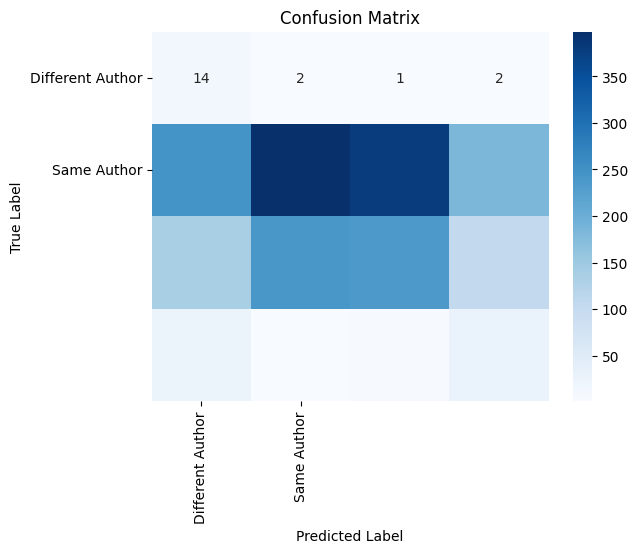

Model coefficients (weights for the features):
hap_jac_sim: 0.18632679226889998
al_jac_sim: -0.294610323642439
svm_score: 1.0199819270223707


In [19]:
# Load your data into a DataFrame (assuming it's already done)
# edges_df = pd.read_sql(df_query, con)

# While testing, limit to 10000 edges or this will take forever.
edges_df = edges_df.sample(10000)

# Select relevant features and target
features = ['hap_jac_sim', 'al_jac_sim', 'svm_score']
X = edges_df[features]
y = edges_df['same_author']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model with balanced class weights
model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Plot confusion matrix with labels
labels = ['Different Author', 'Same Author']
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Coefficients of the model
print("Model coefficients (weights for the features):")
for feature, coef in zip(features, model.coef_[0]):
    print(f"{feature}: {coef}")

Below is all the graphing code. It's commented out for now. 

In [20]:
# G = nx.from_pandas_edgelist(
#     edges_df,
#     source = 'a_text_filename',
#     target = 'b_text_filename',
#     edge_attr = ['comp_score'],
#     create_using = nx.DiGraph)
                            
                            

In [21]:
print(edges_df.sample(n=10))

          pair_id  comp_score  threshold  weight_id  hap_weight  al_weight  \
16295924  4921397       0.742       0.70         21       0.325      0.325   
20228177    14388       0.804       0.80         26       0.350      0.350   
9042714   4676702       0.930       0.90         11       0.550      0.225   
15676694  2167444       0.722       0.80         20       0.400      0.300   
8289338   5467409       0.779       0.90         10       0.225      0.550   
8972274    133624       0.794       0.90         11       0.550      0.225   
8123948   1217253       0.847       0.85         10       0.225      0.550   
6172094   4194212       0.444       0.60          8       0.200      0.200   
11334388  4921019       0.803       0.90         14       0.500      0.250   
14379142  4243454       0.706       0.90         18       0.300      0.400   

          svm_weight  hap_jac_dis  hap_jac_sim  al_jac_dis  ...  a_author_id  \
16295924       0.350     0.929095     0.070905    0.998415  .

In [22]:
#G

In [23]:
# TEXT_FONT_SIZE = 8

In [24]:
# # Position nodes using Fruchterman-Reingold force-directed algorithm
# pos = nx.spring_layout(G)

#  # Draw nodes with labels
# nx.draw(G, width=1, node_size=500, node_color='salmon', with_labels=True)
# # Draw edges with arrows and labels
# edge_labels = nx.get_edge_attributes(G, 'comp_score')
# _ = nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue', font_size=TEXT_FONT_SIZE)


In [25]:
# C = CytoscapeWidget()
# #C.set_layout(name='cola')
# C.set_layout(name='dagre', rankDir='LR', spacingFactor=3)
# C.graph.add_graph_from_networkx(G, directed=True)


In [26]:
# #this is so we can programmatically edit and choose variables for the graph

# def build_style(color_threshold):
#     return [
#         {
#              'selector': 'node',
#              'style': {
#                  'background-color': 'salmon',
#                  'font-family': 'helvetica',
#                  'font-size': f"{TEXT_FONT_SIZE}px",
#                  'label': 'data(id)'
#              }
#         },
#         {
#              'selector': 'edge',
#              'style': {
#                  'line-color': 'black',
#                  'font-family': 'helvetica',
#                  'font-size': f"{TEXT_FONT_SIZE}px",
#                  'color': 'blue',
#                  'label': 'data(comp_score)',
#                 'width': f"mapData(comp_score, {min_comp_score}, {max_comp_score}, 1, 10)"
#                  #'width': '10px',
#              }
#         },
#         {
#             "selector": "edge.directed",
#             "style": {
#                 "curve-style": "bezier",
#                 "target-arrow-shape": "triangle",
#                 "target-arrow-color": "black",
#             }
#         }, 
#         {
#             "selector": f"edge[comp_score>{color_threshold}]",
#             "style": {
#                 "line-color": "red",
#             }
#         },
#     ]
# style = build_style(0.92)
# pprint(style)
# C.set_style(style)

In [27]:
# #make slider

# caption = widgets.Label(value='The slider value is in its initial position.')

# slider = widgets.IntSlider(
#     value=90,
#     min=90,
#     max=100,
#     step=1,
#     description='Test:',
#     disabled=False,
#     continuous_update=False,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )
# def handle_slider_change(change):
#     color_threshold = change.new / 100
#     caption.value = f"The slider value is: {color_threshold}"
#     style = build_style(color_threshold=color_threshold)
#     C.set_style(style)
    
# slider.observe(handle_slider_change, names='value')
# display(caption, slider)

In [28]:
# C

 # MOVE OVER TO CYTOSCAPE APP FOR STRETCHY THINGS



In [29]:
# p4c.cytoscape_ping()

In [30]:
# p4c.cytoscape_version_info()

In [31]:
# p4c.create_network_from_networkx(G)
